# SpikeInterface Tutorial - NWB Breakout Coding Session - the Internet 2020


In this tutorial, we will cover the basics of using SpikeInterface for extracellular analysis and spike sorting comparison. We will be using the `spikeinterface` from the SpikeInterface github organization. 

`spikeinterface` wraps 5 subpackages: `spikeextractors`, `spikesorters`, `spiketoolkit`, `spikecomparison`, and `spikewidgets`.

For this analysis, we will be using a real dataset recorded from CA1 region in the hippocampus (recording from [CINPLA](https://www.mn.uio.no/ibv/english/research/sections/fyscell/cinpla/)). We will show how to:

- load the data with spikeextractors package
- load a probe file
- preprocess the signals
- run a popular spike sorting algorithm with different parameters
- curate the spike sorting output using 1) quality metrics (automatic) - 2) Phy (manual) 
- save the results to NWB!


For this tutorial we will need the following packages:
- spikeinterface
- pyopenephys
- klusta
- tridesclous
- phy
- matplotlib

+ all their dependencies.

To install those you can use the `requirements.txt` in this directory by running the command:

`pip install -r requirements.txt`

If you use a conda environment, you can create the `spiketutorial` environment with:

`conda env create -f environment.yml`

You might need to run:

`ipython kernel install --user --name=tutorial`

or:

`conda install nb_conda_kernels` and change Kernel to run the tutorial notebook.

### Downloading the recording

First, we need to download the recording. Feel free to use your own recordings as well later on.

From this Zenodo [link](https://zenodo.org/record/3256071#.XRHqhnX7Q5k), you can download the dataset mentioned above (`open-ephys-tetrodes.zip`). Move the dataset in the current folder and unzip it.

The recording was performed with the mircodrives with 4 tetrodes each (in total 32 channels).

### Importing the modules

Let's now import the `spikeinterface` modules that we need.

In [1]:
import spikeinterface
import spikeinterface.extractors as se 
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import matplotlib.pylab as plt
import numpy as np
%matplotlib notebook

/Users/abuccino/anaconda3/envs/spikeinterface/lib/python3.6/site-packages/elephant/pandas_bridge.py:22: DeprecationWarning: pandas_bridge module will be removed in Elephant v0.8.x
  DeprecationWarning)
18:14:45 [I] klustakwik KlustaKwik2 version 0.2.6


## Loading recording and probe information

In [2]:
recording_folder = 'open-ephys-dataset/'
recording = se.OpenEphysRecordingExtractor(recording_folder)

Loading Open-Ephys: reading settings.xml...
Decoding data from  binary  format


In [3]:
se.sorting_extractor_full_list

[spikeextractors.extractors.mdaextractors.mdaextractors.MdaSortingExtractor,
 spikeextractors.extractors.mearecextractors.mearecextractors.MEArecSortingExtractor,
 spikeextractors.extractors.exdirextractors.exdirextractors.ExdirSortingExtractor,
 spikeextractors.extractors.hs2sortingextractor.hs2sortingextractor.HS2SortingExtractor,
 spikeextractors.extractors.klustaextractors.klustaextractors.KlustaSortingExtractor,
 spikeextractors.extractors.kilosortextractors.kilosortextractors.KiloSortSortingExtractor,
 spikeextractors.extractors.openephysextractors.openephysextractors.OpenEphysSortingExtractor,
 spikeextractors.extractors.phyextractors.phyextractors.PhySortingExtractor,
 spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusSortingExtractor,
 spikeextractors.extractors.tridescloussortingextractor.tridescloussortingextractor.TridesclousSortingExtractor,
 spikeextractors.extractors.npzsortingextractor.npzsortingextractor.NpzSortingExtractor,
 spike

A `RecordingExtractor` object extracts information about channel ids, channel locations (if present), the sampling frequency of the recording, and the extracellular traces (when prompted). The `OpenEphysRecording` is designed specifically for open-ephys datasets.

Here we load information from the recording using the built-in functions from the RecordingExtractor

In [4]:
channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()

print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)

.dat:  continuous.dat
Estimated samples:  17818112  Numchan:  32
Channel ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Sampling frequency: 30000.0
Number of channels: 32


The `get_traces()` function returns a NxT numpy array where N is the number of channel ids passed in (all channel ids are passed in by default) and T is the number of frames (determined by start_frame and end_frame).

In [5]:
trace_snippet = recording.get_traces(start_frame=int(fs*0), end_frame=int(fs*2))

In [6]:
print('Traces shape:', trace_snippet.shape)

Traces shape: (32, 60000)


The `spikewidgets` module includes several convenient plotting functions that can be used to explore the data:

<IPython.core.display.Javascript object>


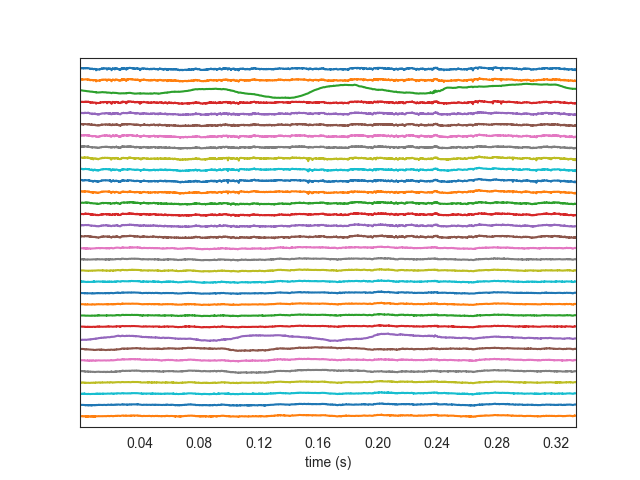

In [7]:
w_ts = sw.plot_timeseries(recording)

We can see that the spikes mainly appear separately on different tetrodes. Each tetrode belongs to a different `group`. We can load the `group` information in two ways:

- using the `set_channel_groups` in your RecordingExtractor (manually loading group information)
- loading a probe file using the `load_probe_file` from RecordingExtractor (automatically loading group information)

Let's use the second option. Probe files (`.prb`) also enable users to change the channel map (reorder the channels) and add channel grouping properties and locations. In this case, our probe file will order the channels in reverse and split them in 4 groups, representing the 4 tetrodes. We'll also add locations to separate the different tetrodes.

In [8]:
# only works on linux and mac. For windows, open the file using a text editor
!cat tetrode_32.prb

channel_groups = {
    # Tetrode index
    0:
        {
        'channels': [0, 1, 2, 3],
	'geometry': [[0,0], [1,0], [2,0], [3,0]],
        },
    1:
      	{
      	'channels': [4, 5, 6, 7],
	'geometry': [[6,0], [7,0], [8,0], [9,0]],
      	},
    2:
      	{
      	'channels': [8, 9, 10, 11],
	'geometry': [[12,0], [13,0], [14,0], [15,0]],
      	},
    3:
      	{
     	 'channels': [12, 13, 14, 15],
	 'geometry': [[18,0], [19,0], [20,0], [21,0]],
     	 },
    4:
	{
        'channels': [16, 17, 18, 19],
	'geometry': [[30,0], [31,0], [32,0], [33,0]],
        },
    5:
      	{
      	'channels': [20, 21, 22, 23],
	'geometry': [[36,0], [37,0], [38,0], [39,0]],
      	},
    6:
      	{
      	'channels': [24, 25, 26, 27],
	'geometry': [[42,0], [43,0], [44,0], [45,0]],
      	},
    7:
      	{
      	'channels': [28, 29, 30, 31],
	'geometry': [[48,0], [49,0], [50,0], [51,0]],
      	}
    }


In [9]:
recording_prb = recording.load_probe_file('tetrode_32.prb')

In [10]:
print('Original channels:', recording.get_channel_ids())
print('Channels after loading the probe file:', recording_prb.get_channel_ids())
print('Channel groups after loading the probe file:', recording_prb.get_channel_groups())

Original channels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Channels after loading the probe file: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Channel groups after loading the probe file: [0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 7]


<IPython.core.display.Javascript object>


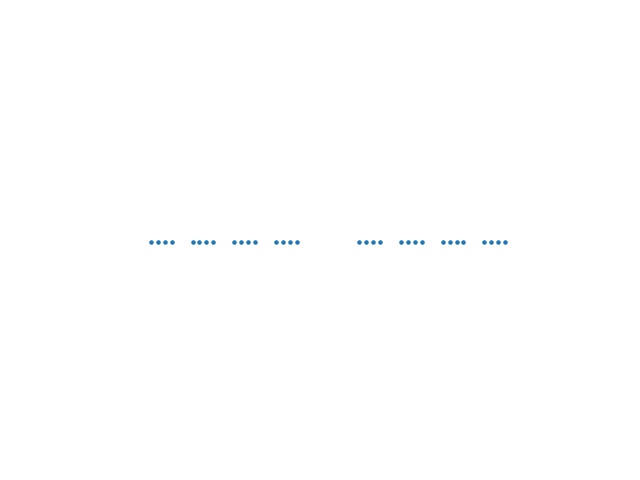

In [11]:
w_elec = sw.plot_electrode_geometry(recording_prb, markersize=5)

### Properties (and features)

For now we have seen that the `RecordingEctractor` can have `group` and `location` *properies*. These are very special properties that can be very important for spike sorting. Anything related to a channel can be saved as a property.

Similarly, for `SortingExtractor` objects, anything related to a unit can be stored as a property. In addition, for `SortingExtractor` objects we can also store anything related to spikes as *features* (e.g. waveforms, as we'll se later).

We can check which properties are in the estractor as follows:

In [13]:
print(recording.get_shared_channel_property_names())
print(recording_prb.get_shared_channel_property_names())

['group']
['group', 'location']


Let's add a new property! The first 16 channels are in the left hemisphere, the second 16 are in the right one:

In [14]:
for ch in recording_prb.get_channel_ids():
    if ch < 16:
        recording_prb.set_channel_property(ch, property_name='hemisphere', value='left')
    else:
        recording_prb.set_channel_property(ch, property_name='hemisphere', value='right')

In [15]:
print(recording_prb.get_shared_channel_property_names())

['group', 'hemisphere', 'location']


## Preprocessing recordings


Now that the probe information is loaded we can do some preprocessing using `spiketoolkit`.

We can filter the recordings, rereference the signals to remove noise, discard noisy channels, whiten the data, remove stimulation artifacts, etc. (more info [here](https://spiketoolkit.readthedocs.io/en/latest/preprocessing_example.html)).

For this notebook, let's filter the recordings, remove a noisy channel, and apply common median reference (CMR). All preprocessing modules return new `RecordingExtractor` objects that apply the underlying preprocessing function. This allows users to access the preprocessed data in the same way as the raw data.

Below, we bandpass filter the recording, remove channel 5, and apply common median reference to the original recording.

<IPython.core.display.Javascript object>


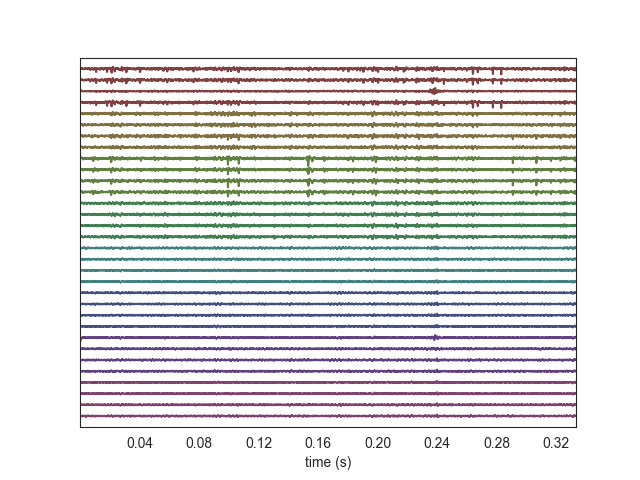

In [16]:
recording_f = st.preprocessing.bandpass_filter(recording_prb, freq_min=300, freq_max=6000)

w = sw.plot_timeseries(recording_f, color_groups=True)

We can see that the first drive is quite active, while the second one is not. For sake of time, we can just focus on the first drive (channels 0-15). We can easily select these channels and get a new extractor using the `SubRecordingExtractor`:

In [17]:
recording_1 = se.SubRecordingExtractor(recording_f, channel_ids=range(16))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]


<IPython.core.display.Javascript object>


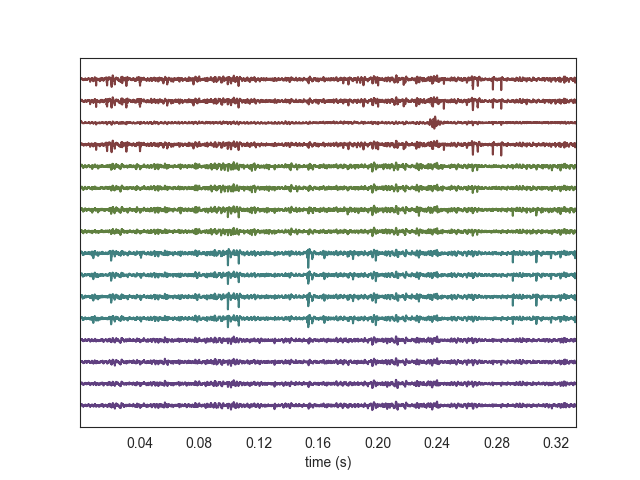

In [18]:
print(recording_1.get_channel_ids())
print(recording_1.get_channel_groups())
w = sw.plot_timeseries(recording_1, color_groups=True)

As we can notice from the first and second plot, channel 2 seems to be a bit noisy. We can remove it using the `remove_bad_channels` function:

In [19]:
recording_rm_noise = st.preprocessing.remove_bad_channels(recording_1, bad_channel_ids=[2])
print(recording_rm_noise.get_channel_ids())

[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [20]:
recording_cmr = st.preprocessing.common_reference(recording_rm_noise, reference='median')

We can plot the traces after removing the bad channel and applying CMR:

<IPython.core.display.Javascript object>


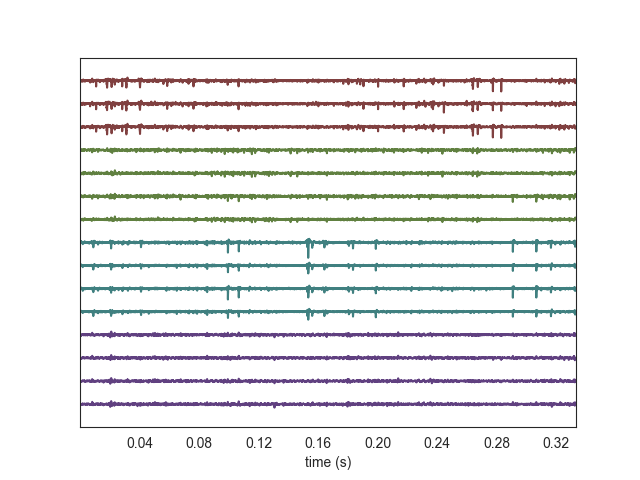

In [21]:
w = sw.plot_timeseries(recording_cmr, color_groups=True)

In [22]:
print('Channel ids for CMR recordings:', recording_cmr.get_channel_ids())
print('Channel groups for CMR recordings:', recording_cmr.get_channel_groups())

Channel ids for CMR recordings: [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Channel groups for CMR recordings: [0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]


Since we are going to spike sort the data, let's first cut out a 2-minute recording, to speed up computations.

In [23]:
fs = recording_cmr.get_sampling_frequency()
recording_sub = se.SubRecordingExtractor(recording_cmr, start_frame=200*fs, end_frame=320*fs)

## Caching 

All operations in SpikeInterface are *lazy*, meaning that they are not performed if not needed. This is why the creation of our filter recording was almost instantaneous. However, to speed up further processing, we might want to **cache** it to a file and perform those operations (eg. filters, CMR, etc.) at once. This is particularly important if we are going to extract waveforms, templates, pca scores, or in general *post-process* the results.

In [24]:
recording_cache = se.CacheRecordingExtractor(recording_sub) 

The cached recording has all the previously loaded information:

In [25]:
print(recording_cache.get_channel_ids())
print(recording_cache.get_channel_groups())
print(recording_cache.get_num_frames() / recording_cache.get_sampling_frequency())

[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]
120.0


Under the hood, this convenient function is retrieving all the traces (in chunks, to save up some memory), applying the preprocessing steps, and dumping them to a binary temporary file:

In [26]:
recording_cache.filename

'/var/folders/vl/0vmqjsjn0dg8ycnxdx_mqrdw0000gr/T/tmp2cjt1gpi/tmp85tpw396.dat'

Note that all extractors (including sorting extractors), have a temporary folder associated with it, that enables SpikeInterface to cache several data (including waveforms) and be gentle on RAM usage:

In [27]:
recording_cache.get_tmp_folder()

PosixPath('/var/folders/vl/0vmqjsjn0dg8ycnxdx_mqrdw0000gr/T/tmp2cjt1gpi')

The temporary files in the tmp folder, are *temporary*, and they will be deleted when the Python session is closed (or the object destroyed). To prevent this, we can simply move the binary file to a custom location:

In [28]:
recording_cache.move_to('filtered_data.dat') 
print(recording_cache.filename)

filtered_data.dat


Alternatively, we could have passed the `save_path` argument to the `se.CacheRecordingExtractor` directly.

## Dumping

If we now closed the Python session, we would have a nice `.dat` file, but no information on how to open it! 
In order to save the state of an extractor, we can use the **dumping** mechanism.
Each extractor can be converted to a dictionary, which holds the path to the data file and all relevant information:

In [29]:
recording_cache.dump_to_dict()

{'class': 'spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor',
 'module': 'spikeextractors',
 'kwargs': {'file_path': '/Users/abuccino/Documents/Codes/spike_sorting/spikeinterface/spiketutorials/NWB_Developer_Breakout_Session_2020/filtered_data.dat',
  'sampling_frequency': 30000.0,
  'numchan': 15,
  'dtype': 'float64',
  'recording_channels': [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
  'time_axis': 0,
  'geom': None,
  'offset': 0,
  'gain': None,
  'is_filtered': True},
 'key_properties': {'group': array([0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]),
  'location': array([[0.00000000e+000, 0.00000000e+000, 4.09940684e+097],
         [1.00000000e+000, 0.00000000e+000, 1.58268989e-319],
         [3.00000000e+000, 0.00000000e+000, 1.72922976e-322],
         [6.00000000e+000, 0.00000000e+000, 1.99602521e-321],
         [7.00000000e+000, 0.00000000e+000, 1.14425604e-320],
         [8.00000000e+000, 0.00000000e+000, 2.43574363

We can now dump our extractor object, so it can be loaded in a future session. We can dump either to `.json` or to `.pkl`. Dumping to pickle also allow us to store properties (other than group and locations) and features (for `SortingExtractor` objects).

In [30]:
recording_cache.dump_to_pickle('recording.pkl')

In another session, we can pick up from where we left by loading the extractor from the pickle file:

In [31]:
recording_loaded = se.load_extractor_from_pickle('recording.pkl')

<IPython.core.display.Javascript object>


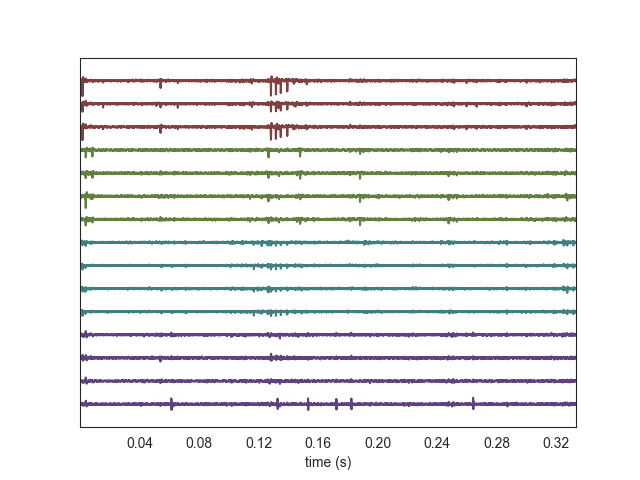

In [32]:
w = sw.plot_timeseries(recording_loaded, color_groups=True)

**IMPORTANT**: the same caching/dumping mechanisms are available also for all SortingExtractor

# Spike sorting

We can now run spike sorting on the above recording. We will use `klusta` and `ironclust` for this demonstration, to show how easy SpikeInterface makes it to interchengably run different sorters :)

Let's first check the installed sorters in spiketoolkit to see if klusta is available. Then we can check the `klusta` default parameters.
We will sort the bandpass cached filtered recording the `recording_cache` object.

In [33]:
ss.installed_sorter_list

[spikesorters.hdsort.hdsort.HDSortSorter,
 spikesorters.klusta.klusta.KlustaSorter,
 spikesorters.tridesclous.tridesclous.TridesclousSorter,
 spikesorters.mountainsort4.mountainsort4.Mountainsort4Sorter,
 spikesorters.ironclust.ironclust.IronClustSorter,
 spikesorters.herdingspikes.herdingspikes.HerdingspikesSorter]

We can retrieve the parameters associated to any sorter with the `get_default_params()` function from the `spikesorters` module:

In [34]:
ss.get_default_params('klusta')

{'adjacency_radius': None,
 'threshold_strong_std_factor': 5,
 'threshold_weak_std_factor': 2,
 'detect_sign': -1,
 'extract_s_before': 16,
 'extract_s_after': 32,
 'n_features_per_channel': 3,
 'pca_n_waveforms_max': 10000,
 'num_starting_clusters': 50}

In [35]:
ss.run_sorter?

In [36]:
ss.run_klusta?

We will set the `adjacency_radius` to 50 microns as electrodes belonging to the same tetrode are within this distance.

In [37]:
# run spike sorting on entire recording
sorting_KL_all = ss.run_klusta(recording_cache, output_folder='results_all_klusta', adjacency_radius=50)
print('Found', len(sorting_KL_all.get_unit_ids()), 'units')

WARNING! The recording contains several group. In order to spike sort by 'group' use grouping_property='group' as argument.
RUNNING SHELL SCRIPT: /Users/abuccino/Documents/Codes/spike_sorting/spikeinterface/spiketutorials/NWB_Developer_Breakout_Session_2020/results_all_klusta/run_klusta.sh
Found 40 units


### Spike sorting by group

Since we have 4 tetrodes and we know that they are physically apart, we would like to sort them separately.

Here is how it's done in SpikeInterface:

![](sort_by_group.png)

In [ ]:
# run spike sorting by group (add picture)
sorting_KL = ss.run_klusta(recording_cache, adjacency_radius=50, 
                                      output_folder='results_split_klusta', 
                                      grouping_property='group', parallel=True)
print('Found', len(sorting_KL.get_unit_ids()), 'units')

In [ ]:
print(type(sorting_KL))

In [ ]:
sorting_KL.sortings

### Installing IronClust (requires MATLAB)

For MATLAB-based sorters, all you need to do is cloning the sorter repo and point it to SpikeInterface:

Let's clone ironclust in the current directory:

In [ ]:
!git clone https://github.com/jamesjun/ironclust

Now all we have to tell the IronClustSorter class where is the ironclust repo:

In [ ]:
ss.IronClustSorter.set_ironclust_path('./ironclust')

Note that we can also set a global environment variable called `IRONCLUST_PATH`. In that case we don't need to set the path in each session because the sorter class looks for this environment variable.

Now ironclust should be installed and we can run it:

In [ ]:
ss.IronClustSorter.ironclust_path

In [ ]:
ss.installed_sorter_list

In [ ]:
# run spike sorting by group
sorting_IC = ss.run_ironclust(recording_cache, 
                                    output_folder='results_split_ic', 
                                    grouping_property='group', parallel=True)
print('Found', len(sorting_IC.get_unit_ids()), 'units')

The spike sorting returns a `SortingExtractor` object. Let's see some of its functions:

In [ ]:
print('Units', sorting_KL.get_unit_ids())

In [ ]:
print('Units', sorting_KL.get_unit_spike_train(13))

We can use `spikewidgets` functions to quickly visualize some unit features:

In [ ]:
w_rs = sw.plot_rasters(sorting_IC, trange=[0,10])

We can now perform some automatic curation by thresholding low snr units on the split sorting result

## Postptocessing

The `postprocessing` submodule of `spiketoolkit` allow us to extract information from the combination of the recording and sorting extractors. For example, we can extract waveforms, templates, maximum channels and pca scores. In addition, we can also compute waveform features that could be used for further processing, e.g. classyfing excitatory-inhibitory neurons.

To extract the waveforms, we can run:

In [ ]:
waveforms = st.postprocessing.get_unit_waveforms(recording_cache, sorting_IC, verbose=True)

In [ ]:
waveforms[0].shape

Similarly, we can get templates, maximum channels, and pca scores. 
Whem these are computed, they are automatically stored in the `SortingExtractor` object, so that they don't need to be recomputed. 

Each waveform is associated with a specific spike, so they are saved as spike *features*:


In [ ]:
sorting_IC_split.get_shared_unit_spike_feature_names()

You may have noticed that 300 waveforms were extracted from the spike train of the first unit. However, it has more spikes:

In [ ]:
len(sorting_IC_split.get_unit_spike_train(0))

It can be convenient to only compute a subset of waveforms to speed up the calculation. The `waveform_idxs` property contains the spike indexes associated with the waveforms.

In [ ]:
print(sorting_IC_split.get_unit_spike_features(0, 'waveforms_idxs'))

Since waveforms are already computed, the next time we (or another function - e.g. `get_unit_templates()`) call it it will just return the stored waveforms.

In [ ]:
waveforms = st.postprocessing.get_unit_waveforms(recording_cache, sorting_IC, verbose=True)

Lighthing fast! 

If we want to recompute the waveforms, for example because we want to extract the waveforms divided by group, we can use the `recompute_info` argument (available for all `postprocessing`, `validation`, and `curation` functions):

In [ ]:
waveforms_group = st.postprocessing.get_unit_waveforms(recording_cache, sorting_IC, 
                                                       grouping_property='group', verbose=True)

In [ ]:
sorting_IC_split.get_shared_unit_property_names()

In [ ]:
for wf in waveforms_group:
    print(wf.shape)

In [ ]:
w_wf = sw.plot_unit_templates(sorting=sorting_IC, recording=recording_cache)

In [ ]:
st.postprocessing.get_template_features_list()

In [ ]:
features = st.postprocessing.compute_unit_template_features(recording_cache, sorting_IC, as_dataframe=True, 
                                                            upsampling_factor=10)
display(features)

## Validation

The `spiketoolkit` package also provides several functions to compute qualitity metrics about the spike sorting results through the `validation` module.

Let's see what metrics are available:



In [ ]:
st.validation.get_quality_metrics_list()

We can either compute one metric at a time, or compute a subset of metrics using the `compute_quality_metrics` function:

In [ ]:
duration = recording.get_num_frames()
isi_violations = st.validation.compute_isi_violations(sorting_IC, duration_in_frames=duration)
print('ISI violations:', isi_violations)

snrs = st.validation.compute_snrs(sorting_IC, recording_cache)
print('SNRs:', snrs)

In [ ]:
quality_metrics = st.validation.compute_quality_metrics(sorting_IC, recording_cache, 
                                                        metric_names=['isi_violation', 'snr'], as_dataframe=True)
display(quality_metrics)

## Curation

### 1) Manual curation using Phy

To perform manual curation we will export the data to Phy. 

In [ ]:
st.postprocessing.export_to_phy(recording_cache, 
                                sorting_IC, output_folder='phy_IC',
                                grouping_property='group', verbose=True, recompute_info=True)

In [ ]:
%%capture --no-display
!phy template-gui phy_IC/params.py

After curating the results we can reload it using the `PhySortingExtractor`:

In [ ]:
sorting_IC_phy_curated = se.PhySortingExtractor('phy_IC/', exclude_cluster_groups=['noise'])

In [ ]:
print(len(sorting_IC_phy_curated.get_unit_ids()))

In [ ]:
st.postprocessing.export_to_phy(recording_cache, 
                                sorting_KL, output_folder='phy_KL',
                                grouping_property='group', verbose=True, recompute_info=True)

In [ ]:
%%capture --no-display
!phy template-gui phy_KL/params.py

### 2) Automatic curation based on quality metrics

In [ ]:
snr_thresh = 5
isi_viol_thresh = 0.5

In [ ]:
sorting_auto = st.curation.threshold_isi_violations(sorting_KL, isi_viol_thresh, 'greater', duration)

In [ ]:
len(sorting_auto.get_unit_ids())

In [ ]:
sorting_auto = st.curation.threshold_snrs(sorting_auto, recording_cache, snr_thresh, 'less')

In [ ]:
len(sorting_auto.get_unit_ids())

### 3) Consensus-based curation 

Can we combine the output of multiple sorters to curate the spike sorting output?

To answer this question we can use the `comparison` module.
We first compare and match the output spike trains of the different sorters, and we can then extract a new `SortingExtractor` with only the units in agreement.

In [ ]:
mcmp = sc.compare_multiple_sorters([sorting_KL, sorting_IC], ['KL', 'IC'])

In [ ]:
w = sw.plot_multicomp_graph(mcmp)
w = sw.plot_multicomp_agreement(mcmp)
w = sw.plot_multicomp_agreement_by_sorter(mcmp)

In [ ]:
agreement_sorting = mcmp.get_agreement_sorting(minimum_agreement_count=2)

In [ ]:
agreement_sorting.get_unit_ids()

In [ ]:
st.postprocessing.export_to_phy(recording_cache, 
                                agreement_sorting, output_folder='phy_AGR',
                                grouping_property='group', verbose=True, recompute_info=True)

In [ ]:
%%capture --no-display
!phy template-gui phy_AGR/params.py

## Save to / load from NWB

In [ ]:
se.NwbRecordingExtractor.write_recording(recording_cache, 'si_tutorial.nwb')

In [ ]:
se.NwbSortingExtractor.write_sorting(sorting_IC, 'si_tutorial.nwb')

In [ ]:
recording_nwb = se.NwbRecordingExtractor('si_tutorial.nwb')
sorting_nwb = se.SortingExtractor('si_tutorial.nwb')